#Pneumonia (viral and bacterial) detection using chest x-ray images 

### Downlading data using kaggle 

In [1]:
pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files

files.upload() # Upload kaggle.json from kaggle --> account --> create new API token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"danielcohennn","key":"39d75423c7e39ed6f2f5d9152f6c98f7"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia # Downloading dataset from kaggle

100% 2.29G/2.29G [00:16<00:00, 160MB/s]
100% 2.29G/2.29G [00:16<00:00, 152MB/s]


In [6]:
!pip install zip_files # For unzipping files 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from zipfile import ZipFile

filename = "chest-xray-pneumonia.zip"

with ZipFile(filename, 'r') as zip:
  zip.extractall()
  print('done')

done


### Loading libraries and data

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score

In [9]:
main_dir = "/content/chest_xray/chest_xray"

train_dir = os.path.join(main_dir, 'train')

test_dir = os.path.join(main_dir, 'test')

train_p_dir = os.path.join(train_dir, 'PNEUMONIA')

train_n_dir = os.path.join(train_dir, 'NORMAL')

test_p_dir = os.path.join(test_dir, 'PNEUMONIA')

test_n_dir = os.path.join(test_dir, 'NORMAL')

train_p_names = os.listdir(train_p_dir)
train_n_names = os.listdir(train_n_dir)
test_p_names = os.listdir(test_p_dir)
test_n_names = os.listdir(test_n_dir)

print("Total images in the training set: ", len(train_p_names+train_n_names))
print("Total images in the test set: ", len(test_p_names+test_n_names))

Total images in the training set:  5218
Total images in the test set:  624


### Visualization and preprocessing 

<function matplotlib.pyplot.show(*args, **kw)>

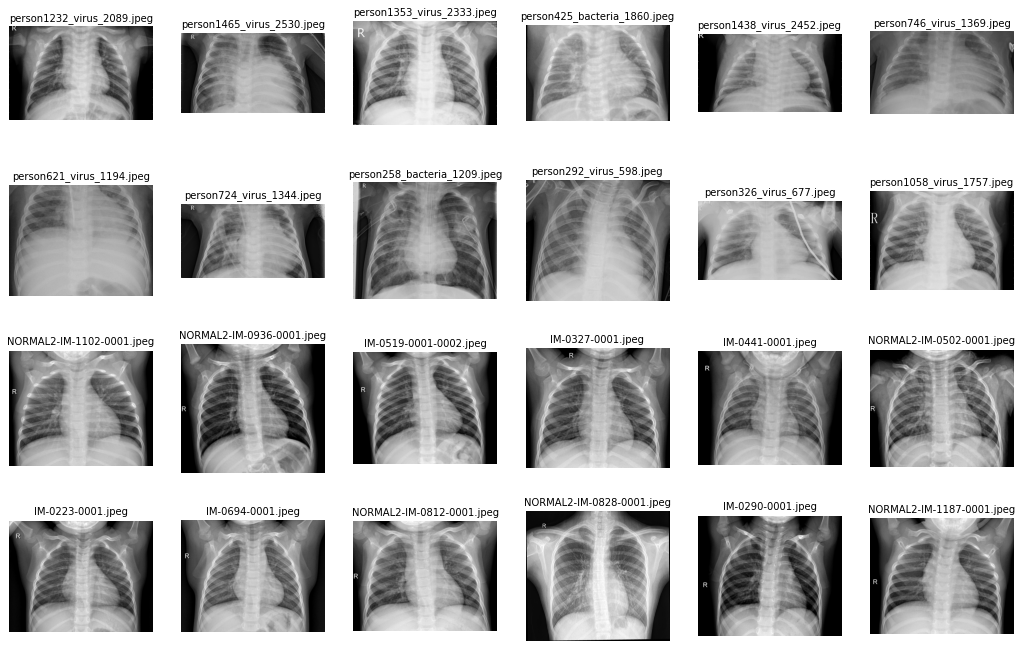

In [10]:
import matplotlib.image as mpimg

r = 6
c = 6

fig = plt.gcf()
fig.set_size_inches(18,18)

p_xray_pictures = [os.path.join(train_p_dir, filename) for filename in train_p_names[0:12]]
n_xray_pictures = [os.path.join(train_n_dir, filename) for filename in train_n_names[0:12]]

lst = p_xray_pictures + n_xray_pictures
for i, img_path in enumerate(lst):
    data = img_path.split('/', 6)[6]
    x = plt.subplot(r, c, i+1)
    x.axis('off')
    img = mpimg.imread(img_path)
    x.set_title(data, fontsize=10)
    plt.imshow(img, cmap='gray')

plt.show

In [11]:
# generate training, testing and validation batches 

data_generate_train = ImageDataGenerator(rescale=1/255, validation_split=0.2, zoom_range=0.2,
                                         horizontal_flip=True)
data_generate_validation = ImageDataGenerator(rescale=1/255)
data_generate_test = ImageDataGenerator(rescale=1/255)

train_gen = data_generate_train.flow_from_directory(train_dir, target_size=(150,150),
                                                          subset='training', batch_size=32,
                                                          class_mode='binary')
validation_gen = data_generate_train.flow_from_directory(train_dir, target_size=(150,150),
                                                          subset='validation', batch_size=32,
                                                          class_mode='binary')
test_gen = data_generate_test.flow_from_directory(test_dir, target_size=(150,150),
                                                          batch_size=32, class_mode='binary')

# class indices
print(train_gen.class_indices)

#image shape
print(train_gen.image_shape)

Found 4173 images belonging to 2 classes.
Found 1043 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}
(150, 150, 3)


### Building, training and predicting model

In [12]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 3)))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

In [13]:
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

trained_model = model.fit(train_gen, epochs=30, validation_data=validation_gen)

Epoch 1/30
131/131 [==============================] - 93s 611ms/step - loss: 0.5918 - accuracy: 0.7426 - val_loss: 0.5617 - val_accuracy: 0.7430
Epoch 2/30
131/131 [==============================] - 77s 589ms/step - loss: 0.4476 - accuracy: 0.7903 - val_loss: 0.3668 - val_accuracy: 0.8456
Epoch 3/30
131/131 [==============================] - 78s 596ms/step - loss: 0.2930 - accuracy: 0.8766 - val_loss: 0.3094 - val_accuracy: 0.8523
Epoch 4/30
131/131 [==============================] - 77s 589ms/step - loss: 0.2321 - accuracy: 0.9109 - val_loss: 0.2202 - val_accuracy: 0.9214
Epoch 5/30
131/131 [==============================] - 78s 593ms/step - loss: 0.2259 - accuracy: 0.9080 - val_loss: 0.3477 - val_accuracy: 0.8255
Epoch 6/30
131/131 [==============================] - 76s 583ms/step - loss: 0.2029 - accuracy: 0.9192 - val_loss: 0.2007 - val_accuracy: 0.9156
Epoch 7/30
131/131 [==============================] - 77s 588ms/step - loss: 0.1965 - accuracy: 0.9248 - val_loss: 0.1937 - val_ac

Text(0.5, 0, 'Epochs')

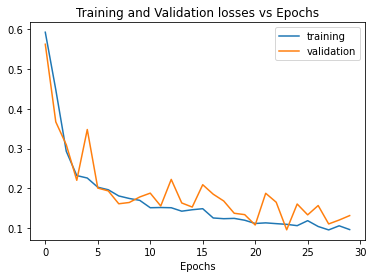

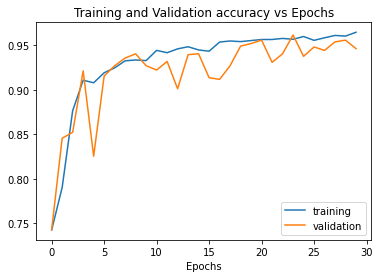

In [14]:
# get keys of trained model
trained_model.history.keys

# plot training and validation loss vs epochs
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation losses vs Epochs')
plt.xlabel('Epochs')

plt.figure()

# plot training and validation accuracy vs epochs
plt.plot(trained_model.history['accuracy'])
plt.plot(trained_model.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training and Validation accuracy vs Epochs')
plt.xlabel('Epochs')

In [15]:
test_loss, test_accuracy = model.evaluate(test_gen)
print(f"Test accuracy: {test_accuracy*100}%, Test loss: {test_loss*100}%")

20/20 [==============================] - 6s 296ms/step - loss: 0.4203 - accuracy: 0.8894
Test accuracy: 88.94230723381042%, Test loss: 42.02951192855835%


In [16]:
predictions_cnn = model.predict(test_gen) # Set of probabilites
y_pred_cnn = predictions_cnn > 0.5
y_true_cnn = test_gen.classes # True labels

In [18]:
Recall = "{:.2f}".format(recall_score(y_true_cnn, y_pred_cnn))
Precision = "{:.2f}".format(precision_score(y_true_cnn, y_pred_cnn))
print(f'Recall score is: {Recall}')
print(f'Precision score is: {Precision}')

Recall score is: 0.70
Precision score is: 0.62


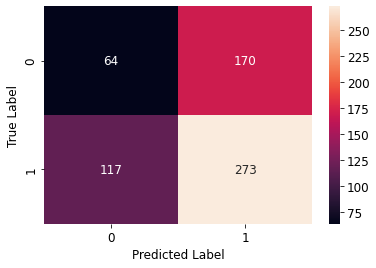

In [20]:
import seaborn as sns

font = {
    'family': 'Times New Roman',
    'size': 12
}
plt.rc('font', **font)
mat = confusion_matrix(y_true_cnn, y_pred_cnn)
sns.heatmap(mat, annot=True, fmt="d")

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

['/content/chest_xray/val/NORMAL/NORMAL2-IM-1436-0001.jpeg', '/content/chest_xray/val/NORMAL/NORMAL2-IM-1440-0001.jpeg', '/content/chest_xray/val/NORMAL/NORMAL2-IM-1442-0001.jpeg', '/content/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg', '/content/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg', '/content/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg']


<function matplotlib.pyplot.show>

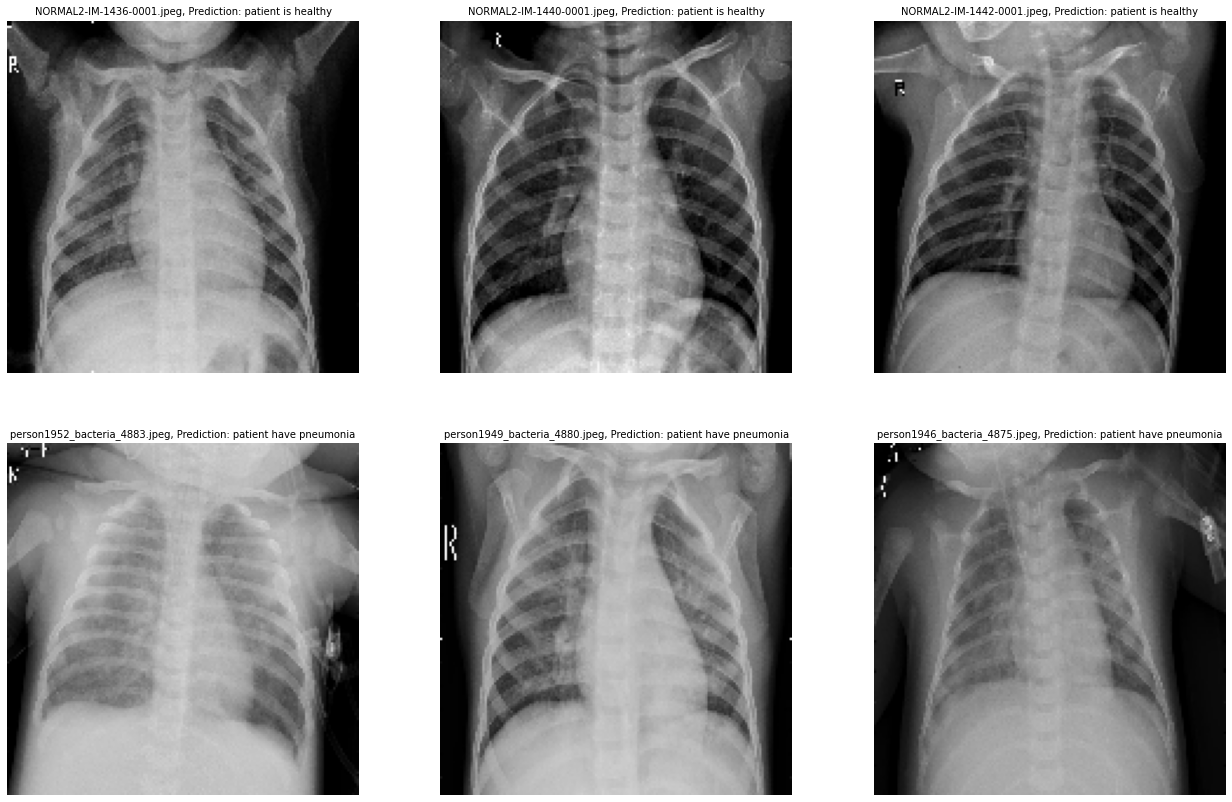

In [ ]:
# predicting on new data
from tensorflow.keras.preprocessing import image

new_pred_dir = '/content/chest_xray'
new_pred_normal = os.path.join(new_pred_dir, 'val/NORMAL')
new_pred_pneumonia = os.path.join(new_pred_dir, 'val/PNEUMONIA')
normal_names = os.listdir(new_pred_normal)
pneumonia_names = os.listdir(new_pred_pneumonia)

normal_pics = [os.path.join(new_pred_normal, filename) for filename in normal_names[3:6]]
pneumonia_pics = [os.path.join(new_pred_pneumonia, filename) for filename in pneumonia_names[3:6]]

merged = normal_pics + pneumonia_pics

r = 3
c = 3

fig = plt.gcf()
fig.set_size_inches(22,22)

for i, filename in enumerate(merged):

  img = image.load_img(filename, target_size=(150,150))
  
  images = image.img_to_array(img)
  images = np.expand_dims(images, axis=0)
  prediction = model.predict(images)
  if prediction == 0:
    pred = 'Prediction: patient is healthy'
  else:
    pred = 'Prediction: patient have pneumonia'
  x = plt.subplot(r, c, i+1)
  x.axis('off')
  x.set_title(filename.split('/')[5] + ', ' + pred, fontsize=10)
  plt.imshow(img, cmap='gray')

plt.show